# Data Generation
## Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import utils.perspective_warp as pw
from pycocotools.coco import COCO
import os
import skimage.io as io

## Constants

In [2]:
IMAGE_DIR = '/mnt/d/workspace/perspectivenet_data_gen/data_dst/images'
ANNOTATION_DIR = '/mnt/d/workspace/perspectivenet_data_gen/data_dst/annotations'
BACKGROUND_IMG_DIR = '/mnt/d/workspace/perspectivenet_data_gen/image_source/background'
FOREGROUND_IMG_DIR = '/mnt/d/workspace/perspectivenet_data_gen/image_source/foreground'
COCO_DATA_DIR = '/mnt/d/workspace/perspectivenet_data_gen/coco_val2014'
COCO_ANNOTATION_FILE_PATH = '/mnt/d/workspace/perspectivenet_data_gen/coco_annotations/instances_val2014.json'

In [3]:
coco = COCO(COCO_ANNOTATION_FILE_PATH)

loading annotations into memory...
Done (t=4.08s)
creating index...
index created!


In [4]:
# get all images containing given categories, select one at random
cat_ids = coco.getCatIds(catNms=['person'])
img_ids = coco.getImgIds(catIds=cat_ids )
img = coco.loadImgs(img_ids[np.random.randint(0,len(img_ids))])[0]

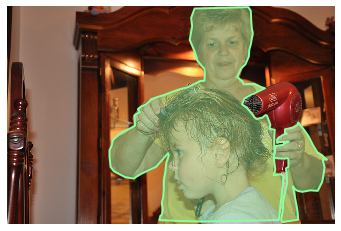

In [5]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(ann_ids)
coco.showAnns(anns)

In [6]:
fg_files = os.listdir(FOREGROUND_IMG_DIR)
bg_files = os.listdir(BACKGROUND_IMG_DIR)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(243, 370, 3)
(332, 500, 3)
resize ratio is 0.7319277108433735, resize shape is [243 365]
(243, 365)
(243, 370, 3)
(243, 370)
(243, 370, 3)


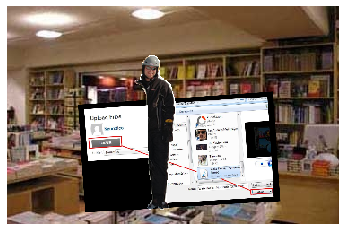

In [30]:
idx = np.random.randint(len(fg_files))
img_f = cv2.imread(os.path.join(FOREGROUND_IMG_DIR, fg_files[idx]))
padding_size_x = np.random.randint(16, 64)
padding_size_y = np.random.randint(16, 64)
img_f = cv2.copyMakeBorder(
    img_f,
    padding_size_y,
    padding_size_y,
    padding_size_x,
    padding_size_x,
    cv2.BORDER_CONSTANT,
    None,
    [0, 0, 0],
)
idx = np.random.randint(len(bg_files))
img_b = cv2.imread(os.path.join(BACKGROUND_IMG_DIR, bg_files[idx]))
# Transformation matrix by random rotation and movement
trans_m = pw.random_perspective_matrix_gen(img_f.shape, img_b.shape)
dst = pw.warp_and_add(img_f, img_b, trans_m)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
coco_img_person = coco.loadImgs(img_ids[np.random.randint(0,len(img_ids))])[0]
img_person = io.imread(coco_img_person['coco_url'])
ann_ids = coco.getAnnIds(imgIds=coco_img_person['id'], catIds=cat_ids, iscrowd=None)
ann = coco.loadAnns(ann_ids)[0]
mask_person = coco.annToMask(ann) * 255
print(mask_person)
# Resizing the person image to contain the person
print(img_b.shape)
print(img_person.shape)
resize_ratio_person = min(img_b.shape[0] / img_person.shape[0], img_b.shape[1] / img_person.shape[1])
resize_shape_person = np.array(img_person.shape[:2], dtype=np.float) * resize_ratio_person
resize_shape_person = resize_shape_person.astype(np.int)
print('resize ratio is {}, resize shape is {}'.format(resize_ratio_person, resize_shape_person))
img_person = cv2.resize(img_person, tuple(resize_shape_person[::-1]))
mask_person = cv2.resize(mask_person, tuple(resize_shape_person[::-1]))
print(mask_person.shape)
print(dst.shape)
img_person = cv2.copyMakeBorder(
    img_person,
    dst.shape[0] - resize_shape_person[0],
    0,
    0,
    dst.shape[1] - resize_shape_person[1],
    cv2.BORDER_CONSTANT,
    None,
    [0, 0, 0],
)
mask_person = cv2.copyMakeBorder(
    mask_person,
    dst.shape[0] - resize_shape_person[0],
    0,
    0,
    dst.shape[1] - resize_shape_person[1],
    cv2.BORDER_CONSTANT,
    None,
    [0],
)
print(mask_person.shape)
print(dst.shape)
img_person = cv2.bitwise_and(img_person, img_person, mask=mask_person)
dst = cv2.bitwise_and(dst, dst, mask=cv2.bitwise_not(mask_person))
dst = cv2.add(dst, img_person)
plt.imshow(dst)
plt.axis('off')
plt.show()

In [31]:
mask_person.dtype

dtype('uint8')